<h1> GAN - CNN</h1>
<u>Vanilla GAN</u>

Dieses Notebook basiert auf "1_intoduce-GAN-ANN". Diesmal wird ein CNN Netz angewendet, um die Qualität zu steigern.

<i>Abb1</i>: Übersicht GAN.

<img src="./data/img/2_gan.PNG" height=500 width=700>

Weitere Inhalte zu GAN:

> GAN Applications: Everything You Need to Know <br>
> https://neptune.ai/blog/generative-adversarial-networks-gan-applications [Letzter Zugriff: 23.07.2024]

Als Erstes werden wir wieder nur eine Klasse nutzen und versuchen mit einem Generator basierend auf CNN ein Bild zu erzeugen.

Als Einstieg soll der Generator ein 100*100 Pixelbild eines Apfels herstellen. 

In [1]:
# Imports.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

Hier werden wir die Funktionsweise des Faltungsnetzes umkehren. Zu Beginn geben wir die Dimension des Bildes an, das dann Hochskaliert wird.

>tf.keras.layers.Conv2DTranspose:<br>
>https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose [Letzter Zugriff: 23.07.2024]

<h2>Dataset</h2>

Wir wollen mit dem Generator syntetische Apfelbilder erzeugen, für das Training nutzen wir ein Dataset das verschiedene Früchte enthählt und wählen eine Sorte aus.

> Fruits-360 dataset: A dataset with 90380 images of 131 fruits, vegetables and nuts. <br>
> https://www.kaggle.com/datasets/moltean/fruits [Letzter Zugriff: 23.07.2024]

In [3]:
url="data/datasets/archive/fruits-360_dataset/fruits-360/Training/Apple_Pink_Lady/"
img = PIL.Image.open(url+"0_100.jpg", mode='r')

In [150]:
np.asarray(img).shape

(100, 100, 3)

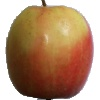

In [151]:
img

In [5]:
appleimage_names = os.listdir(url)
appleimage_names[0]

'0_100.jpg'

In [6]:
# Erstelle Numpy Dataset
apple_dataset = [np.asarray(PIL.Image.open(url+name, mode='r'))  for name in appleimage_names]
len(apple_dataset) == len(appleimage_names)

True

In [7]:
len(appleimage_names)

456

<h2>Aufbau Netz</h2>

In [8]:
image_dim = 100*100
noise_dim = 125

In [15]:
# Generator soll Bild erzeugen.
def create_generator(img_dim:int=125):
    model = tf.keras.Sequential()
    # ---- # 
    model.add(tf.keras.layers.Dense(units=25*25*256, input_shape=(img_dim, ), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape(( 25, 25, 256)))  
    # ---- # 
    # Transpose # 1
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4),  padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU()) 
     # Transpose # 1
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4),  padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU()) 
    # Transpose # 2
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding='same', use_bias=False))  # Durch Strides, Filters und Padding wird Output skaliert.
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  
    # Transpose # 3
    model.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(1,1), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())   
    # Transpose # 4
    model.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())   # leaky

    model.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # Anders als bei einem ANN muss der Output nicht extra 

    return model
    

Beim Konstruieren kann so z. B. der Output und die Form eingesehen und weitere Informationen ausgegeben werden.

Der Aufbau hier ist wieder recht simpel, wenn es darum geht nur eine Klasse eines Bildes zu erzeugen.

In [510]:
noise = np.random.normal(0, 1, (1, 125))  
generator = create_generator(noise_dim)
img = generator(noise)
img.shape

TensorShape([1, 100, 100, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013359457..0.017885402].


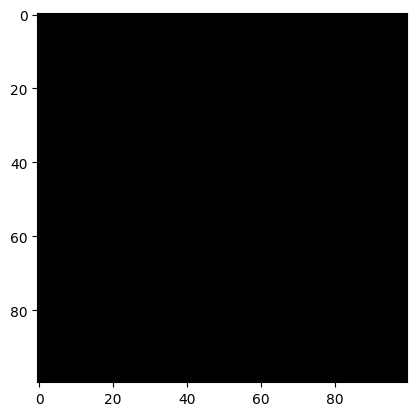

In [447]:
plt.imshow(img[0])

Jetzt kommt der Discriminator.

In [16]:
def create_discriminator():
    model = tf.keras.Sequential()
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(4,4), strides=(1,1), input_shape=(100,100,3), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    return model
    

In [538]:
discriminator = create_discriminator()
discriminator.build(input_shape=(1,104,104,3))
discriminator.summary()

Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 100, 100, 128)     6272      
                                                                 
 leaky_re_lu_377 (LeakyReLU)  (None, 100, 100, 128)    0         
                                                                 
 dropout_69 (Dropout)        (None, 100, 100, 128)     0         
                                                                 
 conv2d_75 (Conv2D)          (None, 50, 50, 64)        32832     
                                                                 
 leaky_re_lu_378 (LeakyReLU)  (None, 50, 50, 64)       0         
                                                                 
 dropout_70 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 50, 50, 16)     

<u>Hinweis:</u><br>
Es gibt verschiedene Arten von GANs wie z. B. Wasserstein-GAN das bessere Ergebnis liefert. Hier geht es darum, sich allgemein mit GAN zu beschäftigen. In anderen Notebooks werden weitere Varianten und Details besprochen sowie deren Unterschiede und Probleme.

<h2>Training 1</h2>

Danach erstellen wir das GAN-Netzwerk und trainieren es.

In [88]:
# Erstelle Modelle. 
generator     = create_generator()
discriminator = create_discriminator()

In [89]:
# Kompiliere Modelle.
generator.compile(optimizer='adam', loss='binary_crossentropy')

discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy'
)

Während des Trainings haben wir die Option generierte Bilder zu speichern. Hier speichern wir das Bild als Array, um es später zu Ploten.

In [90]:
# Trainingsschleife # 
# - Beide Modelle werden trainiert
def train(real_images, generator, discriminator, batch_size: int = 16, epochs: int = 400):
    
    half_batch = int(batch_size / 2)
    # Sammle Loss für Plot.
    d_losses = []
    g_losses = []
    gen_img_array = []

    for epoch in range(epochs):
        idx        = np.random.randint(0, real_images.shape[0], half_batch)  # Ziehe Samples
        real_imgs  = real_images[idx]  # Hole Samples
        noise      = np.random.normal(0, 1, (half_batch, 125))  # Erstelle Startbild- Rauschen.
        
        # Discriminator # 
        with tf.GradientTape() as d_tape:
            
            generated_images = generator(noise, training=True)
            real_output      = discriminator(real_imgs, training=True)
            fake_output      = discriminator(generated_images, training=True)

            # Berechne Loss #
            # discriminator.train_on_batch(<>)
            loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
            loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
            d_loss = tf.reduce_mean(loss_real) + tf.reduce_mean(loss_fake)
            
        # Wende die Gradienten an.
        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator.optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

        # Generator # 
        with tf.GradientTape() as g_tape:
            
            generated_images = generator(noise, training=True)
            fake_output = discriminator(generated_images, training=True)

            # Berechne Loss # 
            g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
            g_loss = tf.reduce_mean(g_loss)

        # Wende Gradienten an.
        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

        print(f"Epoch: {epoch + 1}/{epochs} D_loss: {d_loss.numpy()} G_loss: {g_loss.numpy()}")
        d_losses.append(d_loss)  # Hänge Loss an für den Plot. 
        g_losses.append(g_loss)
        if epoch%200==0:
            gen_img_array.append(generator.predict(noise))

    return gen_img_array, d_losses, g_losses


In [91]:
# Skaliere. 
numpy_images = (np.asarray(apple_dataset) - 127.5) / 127.5

In [92]:
generated_img, d_losses, g_losses = train(numpy_images, generator, discriminator, 8, 801)

Epoch: 1/801 D_loss: 1.3685400485992432 G_loss: 0.8986726999282837
1/1 [==============================] - 0s 171ms/step
Epoch: 2/801 D_loss: 0.787701427936554 G_loss: 1.1655492782592773
Epoch: 3/801 D_loss: 0.47823068499565125 G_loss: 2.0708558559417725
Epoch: 4/801 D_loss: 0.20449253916740417 G_loss: 3.8206920623779297
Epoch: 5/801 D_loss: 0.034725867211818695 G_loss: 6.443331718444824
Epoch: 6/801 D_loss: 0.003899993607774377 G_loss: 8.984976768493652
Epoch: 7/801 D_loss: 0.0004810997925233096 G_loss: 11.032981872558594
Epoch: 8/801 D_loss: 7.100473158061504e-05 G_loss: 12.776884078979492
Epoch: 9/801 D_loss: 0.00043272459879517555 G_loss: 14.248952865600586
Epoch: 10/801 D_loss: 1.363152296107728e-05 G_loss: 15.100903511047363
Epoch: 11/801 D_loss: 1.1132770850963425e-05 G_loss: 14.74449348449707
Epoch: 12/801 D_loss: 0.08455627411603928 G_loss: 10.570341110229492
Epoch: 13/801 D_loss: 0.0008641979657113552 G_loss: 6.449741363525391
Epoch: 14/801 D_loss: 0.132642462849617 G_loss: 5.

Mit weiteren Optimierungen können die Netze besseren Output liefern.

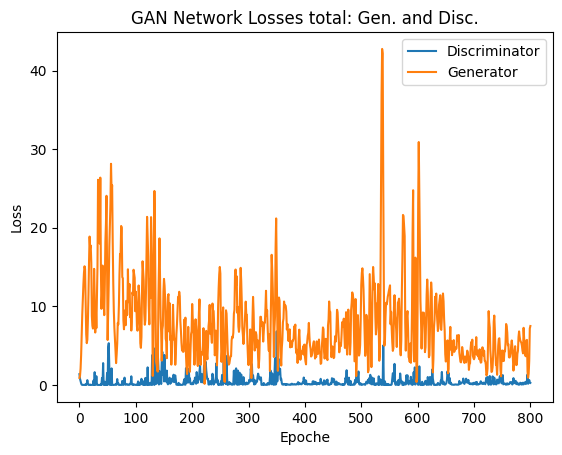

In [93]:
#plt.figure(figsize=(16, 8))
plt.title("GAN Network Losses total: Gen. and Disc.")
plt.xlabel("Epoche")
plt.ylabel("Loss")

plt.plot(range(len(d_losses)), d_losses, label="Discriminator")
plt.plot(range(len(g_losses)), g_losses, label="Generator")
plt.legend()

Um den Fortschritt sichtbar zu machen werden die Bilder die gesammelt wurden in einem Plot gezeigt. 

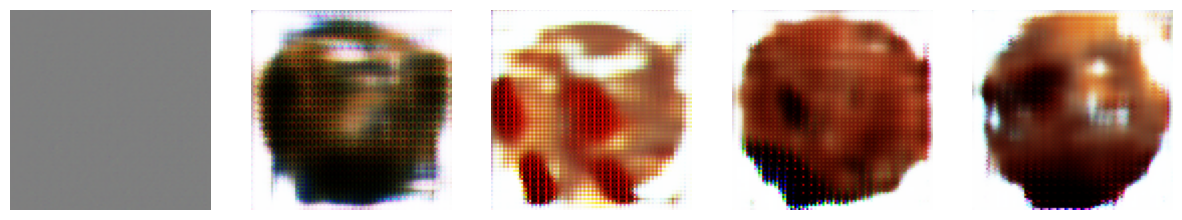

In [94]:
fig, axs = plt.subplots(1,len(generated_img), figsize=(15, 6))
axs = axs.ravel()

for i in range(len(generated_img)):
    img = generated_img[i][0]
    img  = (img * 127.5 + 127.5).astype(np.uint8)
    axs[i].set_axis_off()
    axs[i].imshow(img)

1/1 [==============================] - 0s 29ms/step


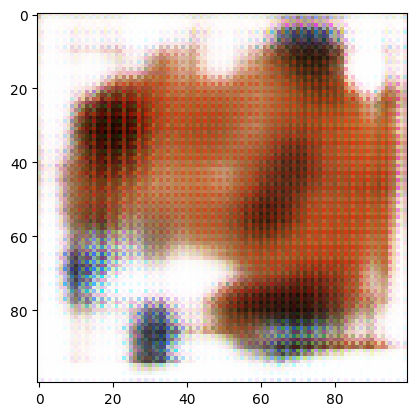

In [84]:
# Generiere ein Bild.
noise = np.random.normal(0, 1, (1, 125))  
fake_img = generator.predict(noise)
generated_image = (fake_img * 127.5 + 127.5).astype(np.uint8)
plt.imshow(generated_image[0])

<h2>Training 2</h2>

Hier wollen wir das Training etwas anders gestalten. 

<h2>Training 3</h2>

In [115]:
def create_GAN(gen, disc):
    # Kombiniere.
    gan_input   = tf.keras.layers.Input(shape=(125,))  
    gen_output = generator(gan_input)

    disc_output = discriminator(gen_output)
    GAN         = tf.keras.Model(gan_input, disc_output)

    GAN.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# // Content coming